# COVID19

In the previous assignment, you developed a particle-based simulation of disease spread. An infected individual infected other individuals when it encountered them. The individuals then recovered from the infection after a certain time and became immune to further infections. We now take a look at a model of disease spread that describes the same problem in terms of three coupled differential equations. This is the Kermack-McKendrick or SIR (Susceptible-Infected-Removed) model.

In [22]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import diags
from scipy.integrate import odeint
import requests
import io
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

plt.rcParams.update({'font.size': 10,
                     'lines.linewidth': 1,
                     'lines.markersize': 5,
                     'axes.labelsize': 10,
                     'xtick.labelsize' : 9,
                     'ytick.labelsize' : 9,
                     'legend.fontsize' : 8,
                     'contour.linewidth' : 1,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'figure.figsize': (4, 3),
                     'figure.dpi': 150 }) 

def get_size(w,h):
    return((w/2.54,h/2.54))

## The Kermack-McKendrick Model

The Kermack-McKendrick model, proposed in 1927 by W.O. Kermack and A.G. McKendrick, is a foundational compartmental model in epidemiology that describes the spread of an infectious disease through a closed population over time.

The model divides the population into three compartments:

1. Susceptible (S): Individuals who are capable of contracting the disease.

2. Infected (I): Individuals who have the disease and can transmit it to susceptible individuals. 

3. Removed (R): Individuals who have either recovered from the disease with immunity or have died from it, and can no longer transmit it.

The model makes the following key assumptions:

- The population is closed (no births, deaths, or migration).
- All individuals are initially susceptible except for a few infected individuals.
- Recovered individuals are permanently immune.
- The disease transmission is frequency-dependent (new infections occur through random contacts between susceptible and infected individuals).

The dynamics of the model are governed by a system of three coupled, non-linear ordinary differential equations:

$$
\frac{dS}{dt} = -I S \frac{\beta}{N}
$$

$$
\frac{dI}{dt} = \beta S\frac{I}{N}- \gamma I  
$$

$$
\frac{dR}{dt} = \gamma I
$$

Where:
- $\beta$ is the effective contact rate (average number of adequate contacts per unit time)
- $\gamma$ is the recovery rate ($1/\gamma$ is the mean infectious period)
- $N$ is the total population size (N = S + I + R)

The key parameter is the basic reproduction number $R0 = \beta/\gamma$, which represents the average number of secondary infections caused by a single infected individual in a fully susceptible population. If $R0 < 1$, the disease will die out. If $R0 > 1$, the disease can spread and cause an epidemic.

The model predicts that the number of infected individuals will initially grow exponentially, reach a peak, and then decline as the number of susceptible individuals decreases and the number of removed individuals increases. The final size equation gives the fraction of the population that will be infected at the end of the epidemic.

While simple, the Kermack-McKendrick model captures the essential dynamics of infectious disease spread and has been the basis for more complex and realistic epidemic models.

The Kermack-McKendrick model (KM) was an early compartmental model. It divides the population into three groups: Susceptible (S), Infected (I) and Removed (R). These models are often referred to as **SIR** models. However, in the simple model below, there is no population that is removed by death or so, but we will implement the removal as well.

Kermack and McKendrick developed their model to further their understanding of epidemics, where an infected individual enters a population and suddenly begins to spread the disease. They assumed that the population remains constant (apart from deaths, which are represented in the model by the term R), so that all effects of births, non-disease-related deaths and migration into or out of the target area are ignored. In addition, all individuals are equally susceptible, so there are no bonus points in this model for those who are healthier or have better hygiene habits. These are all limitations of the model, but they also make it an excellent starting point for epidemiological studies. 

## Setup

Here we define again our initial parameters and the initial conditions. We would like to run the simulation for 

* $N=1000$ people 
* $i=1$ infected people at the beginning
* $n=200$ timesteps of the simulation, i.e. days

We chose the individual rates the following way

* $\beta=0.5$ the rate of infection, multiplication with n gives the number of people infected by one individual per day
* $\gamma=0.1$ the rate of recovery, this means here 10 days for recovery
* $\delta=0.05$ the rate of death, if we include death as well

These rates are just guesses (well I tried earlier), but you might want to map the earlier particle based simulation onto this model to compare the dynamics observed both.

In [23]:
N=1000 # total people
I=1 # infected people
state=[N-I,I,0] # initial state
n=200

t=np.linspace(0,200,n)

## Definition

Our `covid19` function now implements the differential equations above into a function. This is rather straight forward, as they are only first order differential euqations.

In [42]:
def covid19(state , time):
    beta=0.4/N ## infection rate
    gamma=1/10 ## recovery rate 
    delta=0.05 ## death rate
    g0 = -beta*state[0]*state[1]
    g1 = beta*state[0]*state[1]-gamma*state[1] #- delta*state[1]
    g2 = gamma*state[1]
    
    return(np.array([g0, g1, g2]) )

## Solution

The following code solves the coupled differential equations and sorts the solution into individual arrays for further plotting.

In [43]:
answer = odeint( covid19, state , t ) 

susceptible=answer[:,0]
infected=answer[:,1]
recovered=answer[:,2]
#dead=N-np.sum(answer[:,:],axis=1)

## Plotting

We can now plot the solution of the model. You see that after some delay, the number of infected people quickly increases until the recovery sets in. Then the number of infected people decreases again until all are recovered. You may change the above rate of death now to see how it effects the diagram. You can now play around and check out what happens if you increase the recovery or infection rate. 

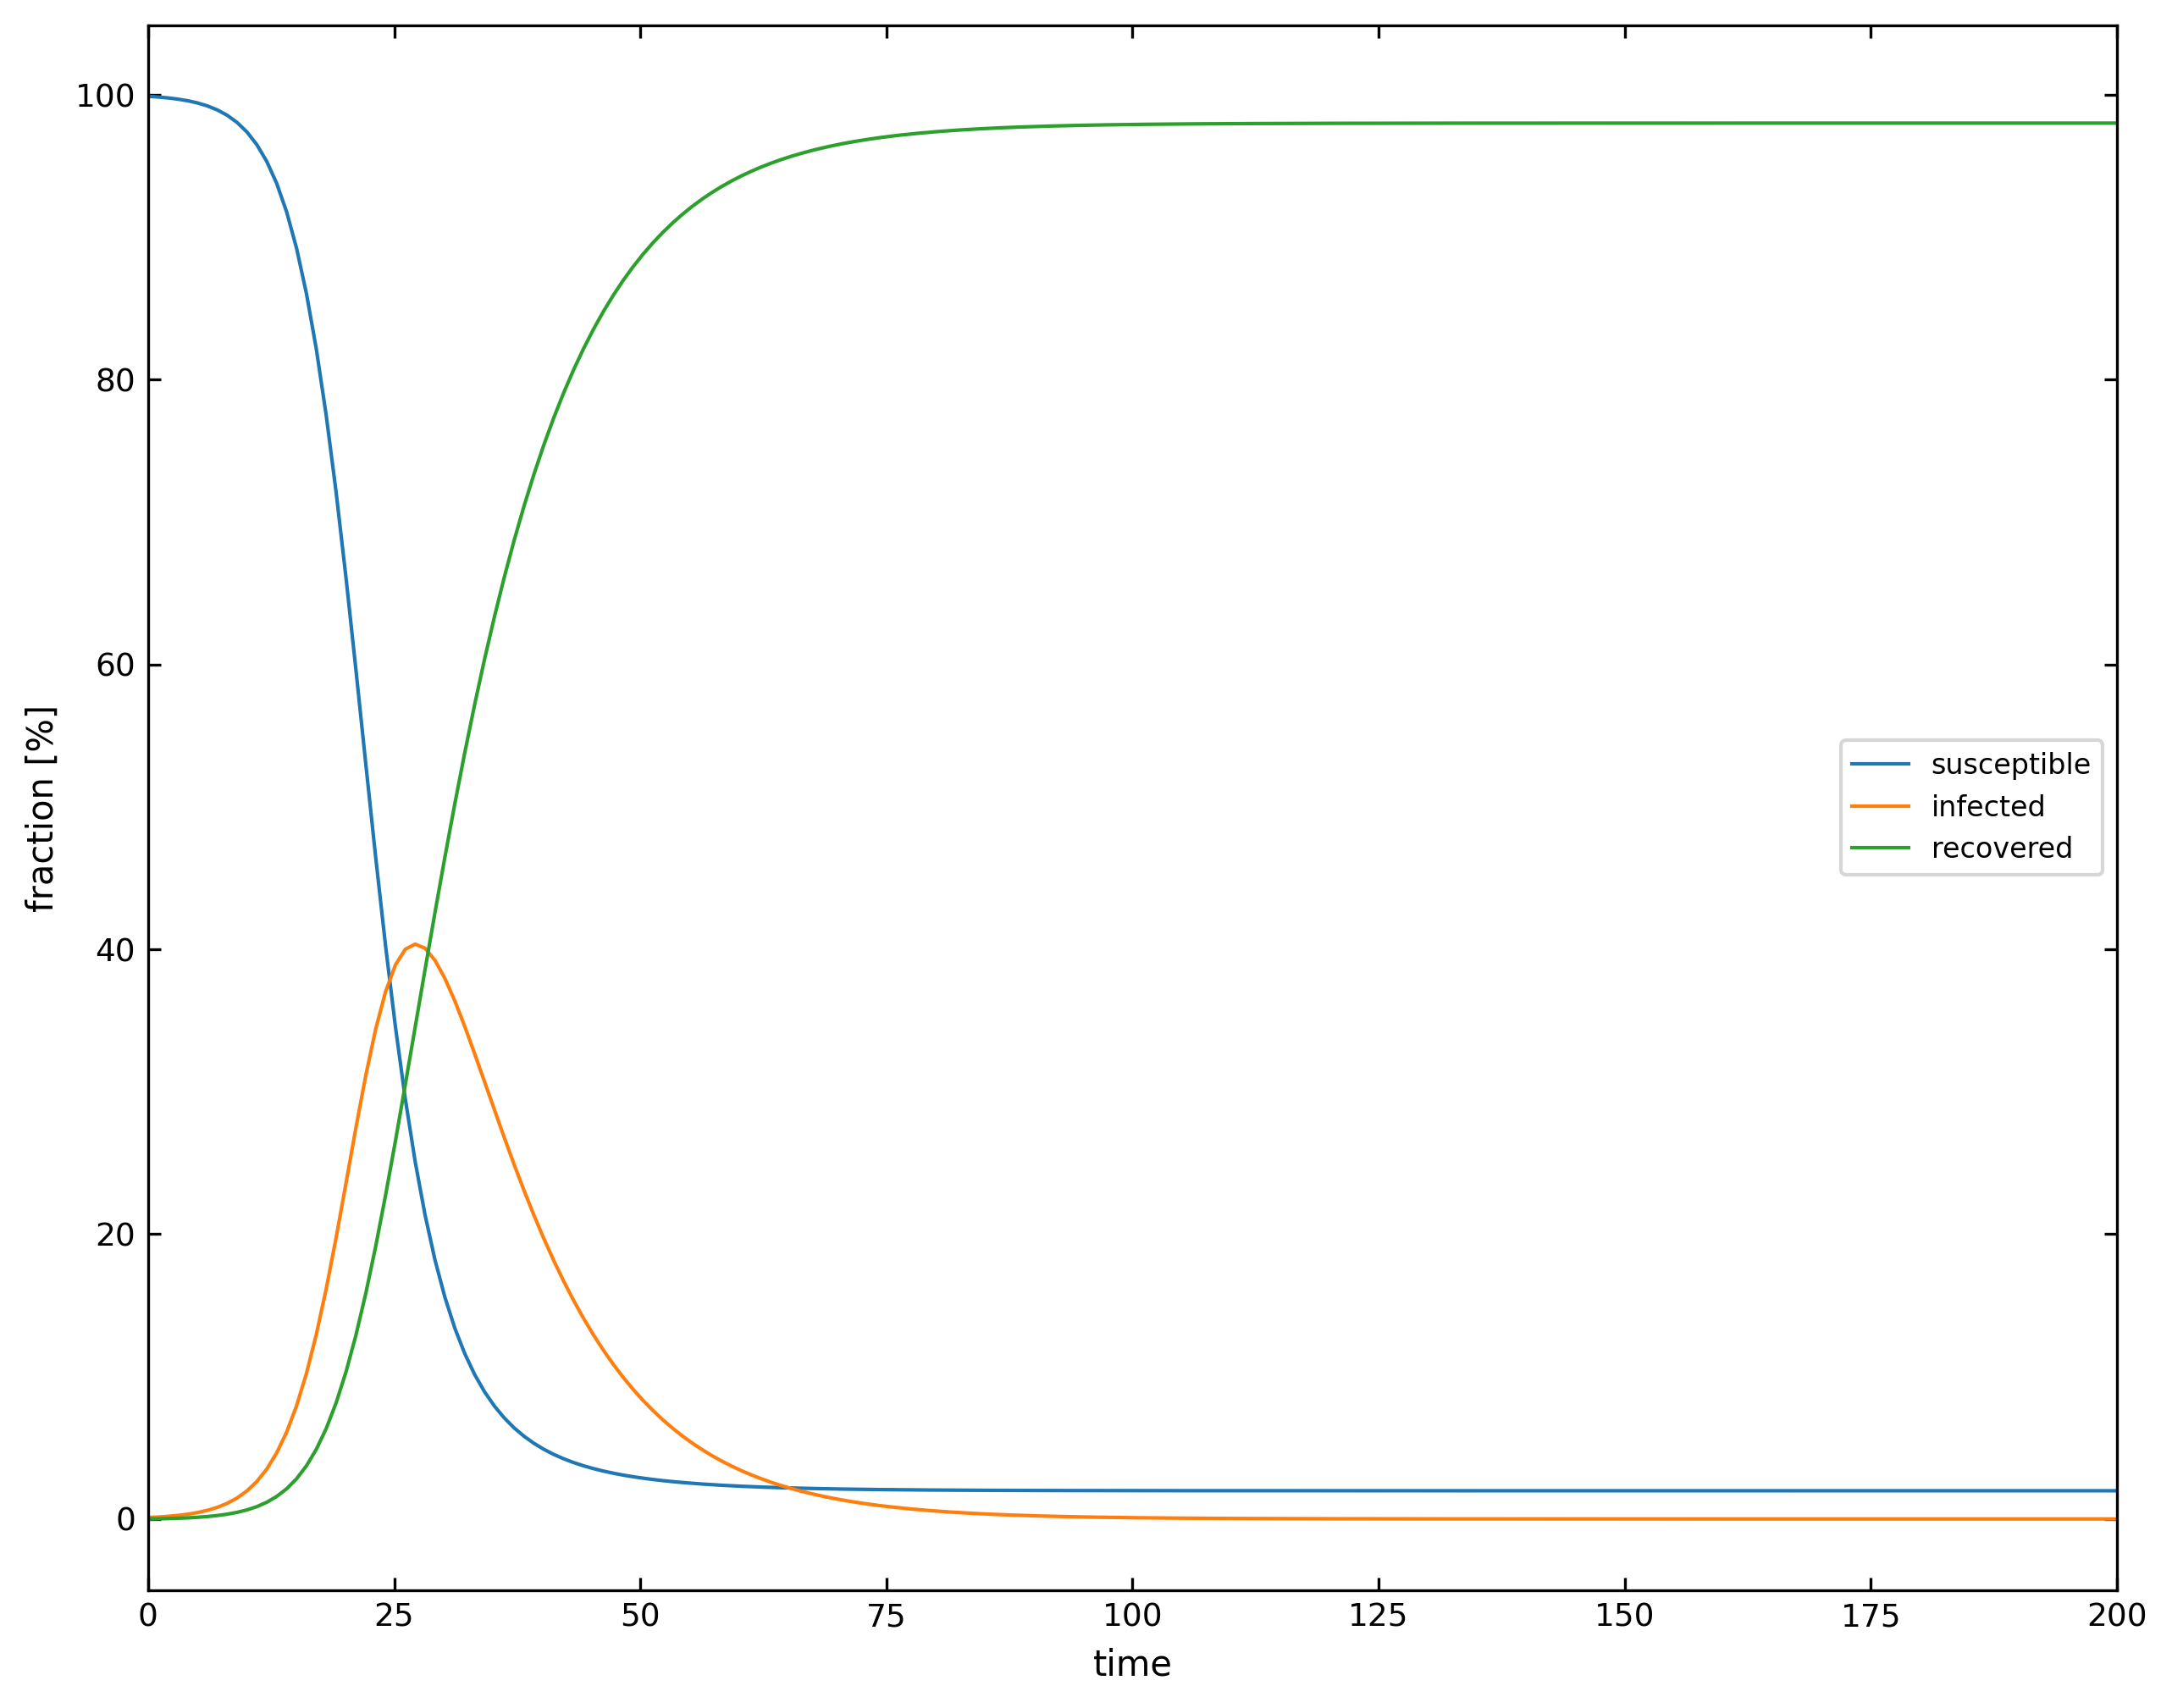

In [44]:
percent=100/N
plt.figure(figsize=(10,8))
plt.plot(t,susceptible*percent,label='susceptible')
plt.plot(t,infected*percent,label='infected')
plt.plot(t,recovered*percent,label='recovered')
#plt.plot(t,dead*percent,label='dead')
plt.xlabel('time')
plt.ylabel('fraction [%]')
plt.legend()
plt.xlim(0,200)
plt.show()

## Real COVID19 numbers

To compare the behavior to the current pandemic, I have downloaded some the current data for 5 different countries and stored them in the `covid19.csv` file. The data file reports
**Date**, **Country**, **Confirmed**, **Recovered** and **Deaths**. To make the data comparable, I have already normalized the cases to the population of the country and multiplied by 1 million.
That means the data is showsing the number of cases per million.

In [45]:
cut=pd.read_csv('covid19.csv')

### Total number of cases

To analyze the current situation we want to plot the total number of cases. To make the data more comparable, we do the following calculations. We first normalize the number of cases to the total population of the country. I have done that already in the dataset as mentioned above. The second issue is, that one should compare the data of different countries, when the total number of cases per million inhabitants crosses one for example. That is the only useful way to compare data. Note that this is a cummulative number. 

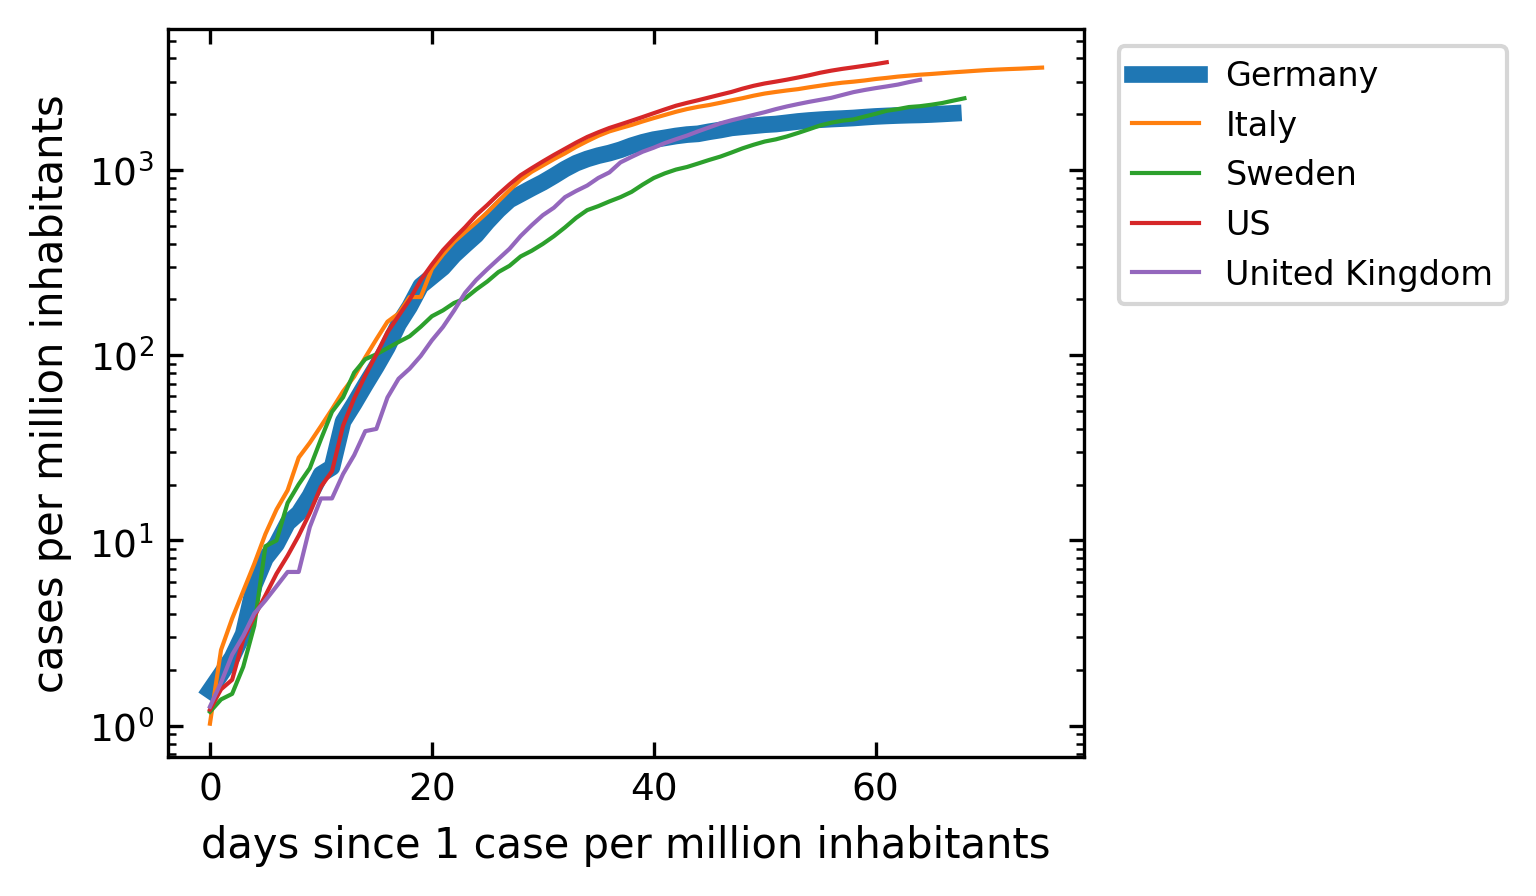

In [47]:
plt.figure(figsize=get_size(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Confirmed>1].Confirmed.values
    if c=='Germany':
        lw=4
    else:
        lw=1
    plt.semilogy(cases,label=c,lw=lw);
 
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel('days since 1 case per million inhabitants')
plt.ylabel('cases per million inhabitants')
plt.show()

### Number of Deaths

The graph below does the same analysis as the one for the confimed cases, but only for the number of death. While the differences in the cummulative numbers of confirmed cases are small, the number of death per million in the countries show already some differences in the total death. Yet the kinetics is still similar.

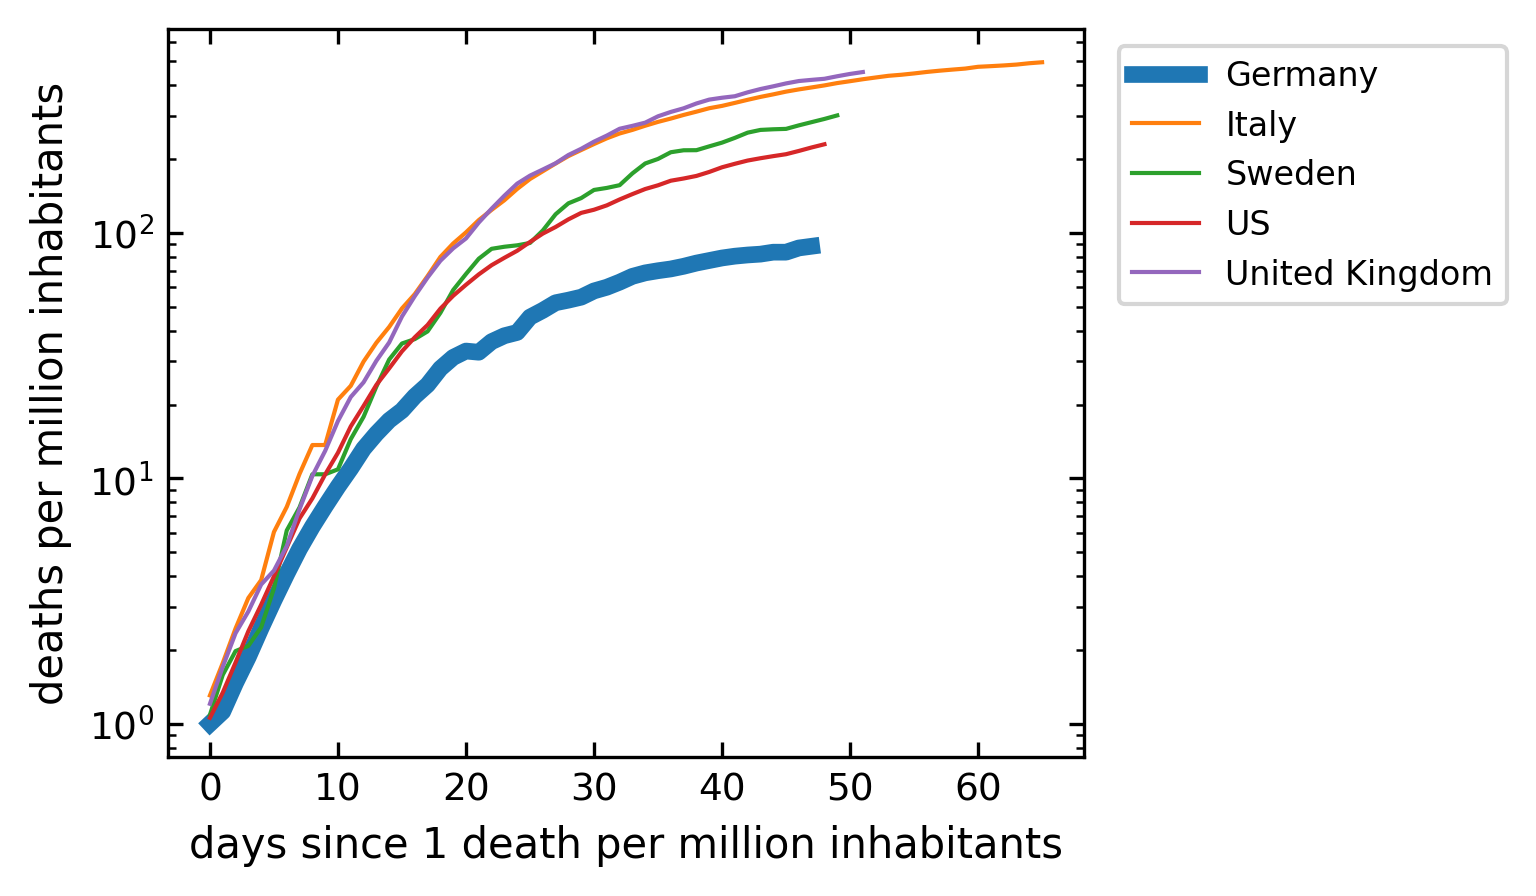

In [48]:
plt.figure(figsize=get_size(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Deaths>1].Deaths.values
    if c=='Germany':
        lw=4
    else:
        lw=1
    plt.semilogy(cases,label=c,lw=lw);

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel('days since 1 death per million inhabitants')
plt.ylabel('deaths per million inhabitants')
plt.show()
    

### New cases per day

The next plot is comparing the new cases that appear per million people each day. Have a look at how this is done with the help of pandas. The data would be rather "noisy" as this is just the derivative of the confirmed cases curve. To smooth that out, I have included a rolling average. This rolling average takes the average of 5 following days and the moves one day forward each time. You may recognize the different dynamics in the countries 

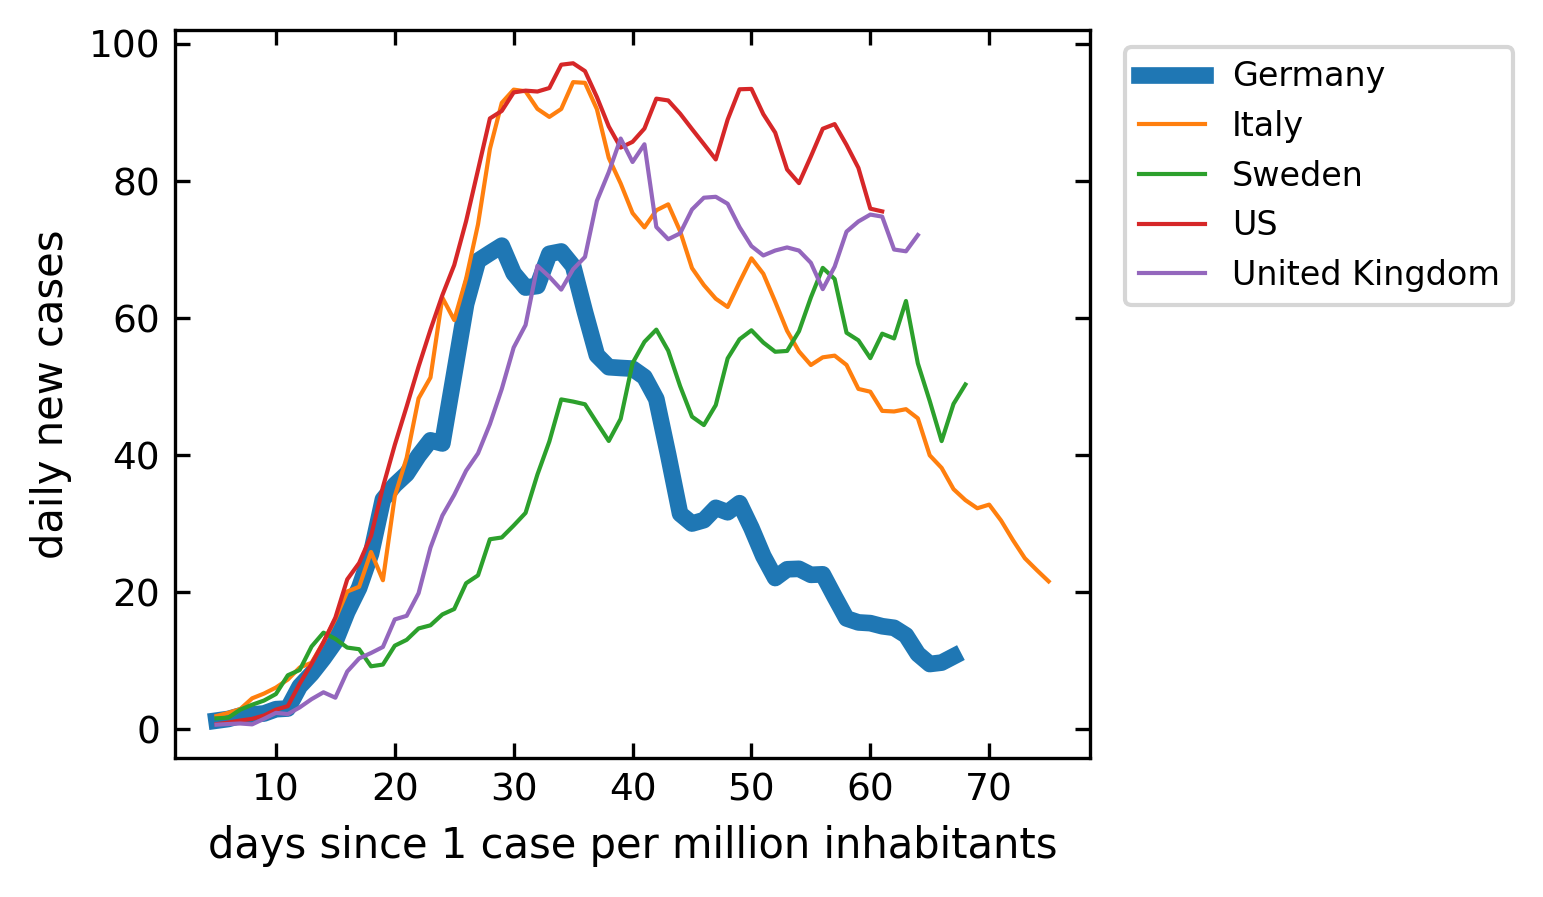

In [50]:
plt.figure(figsize=get_size(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Confirmed>1].Confirmed
    new_cases=cases.diff(1).rolling(5).mean()
    if c=='Germany':
        lw=4
    else:
        lw=1    
    #plt.plot(cases.diff().values,label=c);
    plt.plot(new_cases.values,label=c,lw=lw)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel('days since 1 case per million inhabitants')
plt.ylabel('daily new cases')
plt.show()

### Current cases

The last plot is the number of current active cases. This can be calculated from the total number of cases when we subtract the recovered and the death. This curve should roughly correspond in its shape to the model above. Think about, how the model is different from the real data.

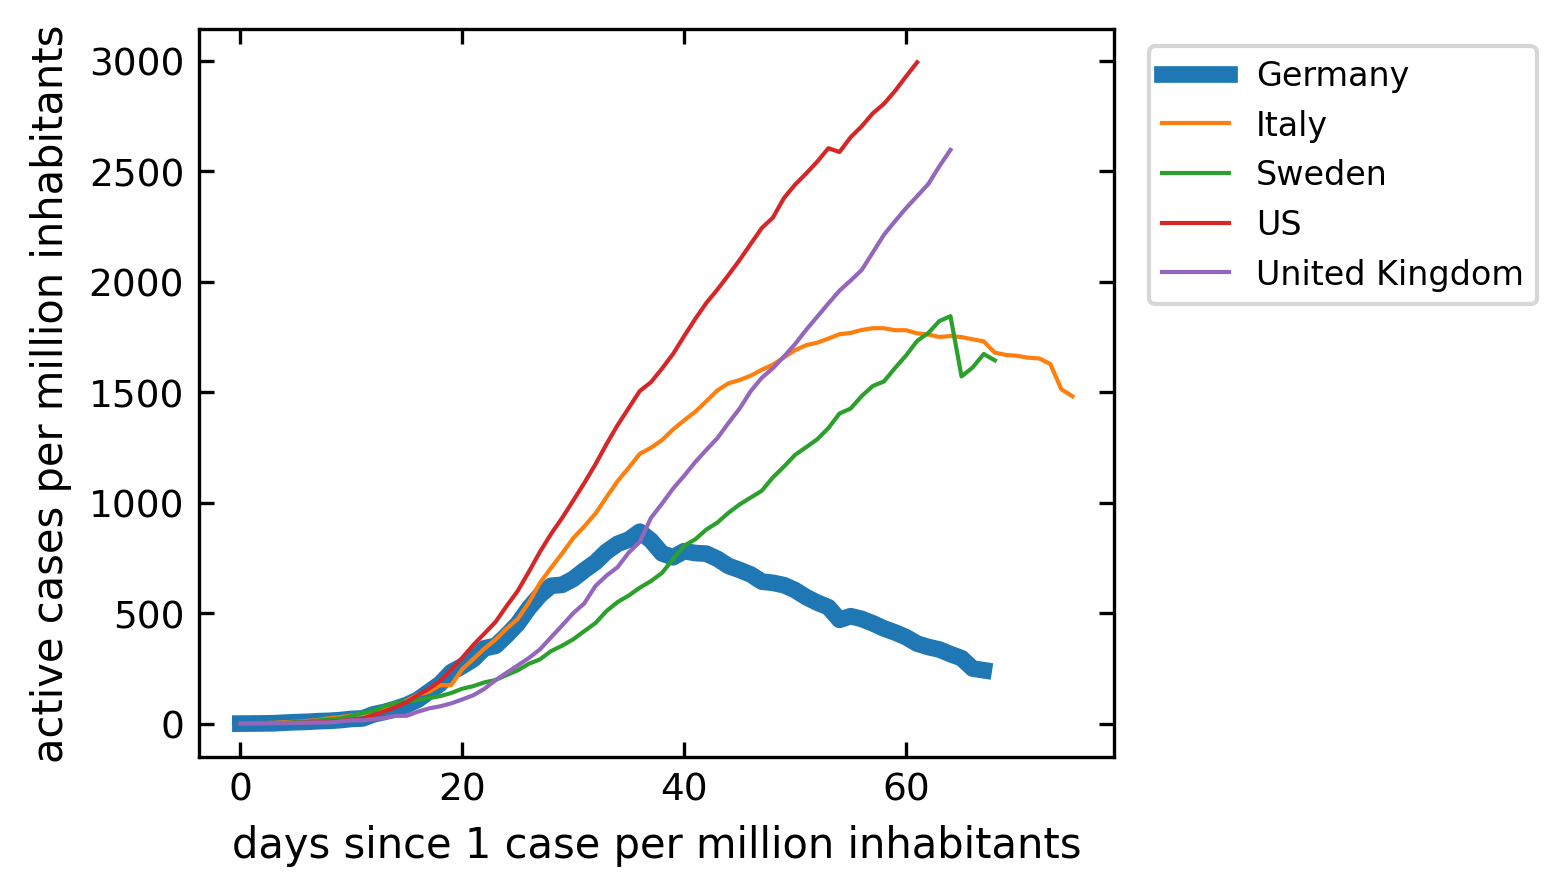

In [51]:
plt.figure(figsize=get_size(10,8))
for c in cut.Country.unique():
    df=cut[cut.Country==c]
    cases=df[df.Confirmed>1].Confirmed.values-df[df.Confirmed>1].Recovered.values-df[df.Confirmed>1].Deaths.values
    if c=='Germany':
        lw=4
    else:
        lw=1
    plt.plot(cases,label=c,lw=lw);

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel('days since 1 case per million inhabitants')
plt.ylabel('active cases per million inhabitants')
plt.show()